# Co-occurence Analysis

## To import all modules

In [1]:
!pip install adjustText
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap, Normalize
import networkx as nx
from adjustText import adjust_text
import esupar


[notice] A new release of pip available: 22.3 -> 24.0
[notice] To update, run: pip install --upgrade pip


## To load data

In [2]:
df_ren = pd.read_csv('data/data_ren.csv')

In [3]:
df_ren.head()

,Unnamed: 0.1,Unnamed: 0,Item1,Item2,book,chapter,sentences_index,contain_ren,Start,End
0,0,510,孝,仁,analects,学而,5,True,-480,-350
1,1,518,弟,仁,analects,学而,5,True,-480,-350
2,2,525,也,仁,analects,学而,5,True,-480,-350
3,3,531,者,仁,analects,学而,5,True,-480,-350
4,4,536,其,仁,analects,学而,5,True,-480,-350


## To set time attributes

In [4]:
def set_average_year(df):
    df["average_year"] = None
    for i in range(df.shape[0]):
        df.loc[i, 'average_year'] = (df.loc[i, 'Start'] + df.loc[i, 'End'])/2
    df.head()
    return df
def set_ren_in_Item2(df):
    for i in range(df.shape[0]):
        if "仁" == df["Item1"][i]:
            df.loc[i, "Item1"] = df.loc[i, "Item2"]
            df.loc[i, "Item2"] = "仁"
    return df

In [5]:
df_ren = set_average_year(df_ren)
df_ren = set_ren_in_Item2(df_ren)

## To extract all combinationt that include benevolence and keywords

In [6]:
def extract_combination_from_keywords(df, keywords):
    """
    This function extracts rows from the input dataframe where "Item1" is in the specified keywords and "Item2" is "仁".

    Parameters:
    df (pandas.DataFrame): The input dataframe. It should contain columns named "Item1" and "Item2".
    keywords (list): A list of keywords. If "Item1" is in this list and "Item2" is "仁", the row is extracted.

    Returns:
    pandas.DataFrame: A dataframe with the same columns as the input dataframe. It contains the extracted rows.
    """
    extracted_df = pd.DataFrame(columns=df.columns)
    rows_to_add = []
    for i in range(df.shape[0]):
        if df.loc[i, "Item1"] in keywords:
            if df.loc[i, "Item2"] == "仁":
                rows_to_add.append(df.loc[[i]])
    if rows_to_add:
        extracted_df = pd.concat([extracted_df] + rows_to_add, ignore_index=True)
    return extracted_df

In [7]:
keywords_Human_ethics = ["贤", "礼", "中", "和", "小", "经", "常", "伦", "孝", "正", "圣", "尊", "亲"]
keywords_Political_Governance = ["君", "臣", "天", "命", "道", "德", "父", "子", "妻", "家", "国", "政", "治", "法", "心"]
keywords_Human_Life = ["善", "恶", "义", "知", "信", "性", "欲", "有", "无", "修", "齐", "贵", "贱", "人", "生"]

In [8]:
df_ren_Human_Ethics = extract_combination_from_keywords(df_ren, keywords_Human_ethics)
df_ren_Political = extract_combination_from_keywords(df_ren, keywords_Political_Governance)
df_ren_Human_Life = extract_combination_from_keywords(df_ren, keywords_Human_Life)

## To make weight and split data into three periods

In [9]:
def make_weight(df):
    """
    This function calculates the weight of each pair of items in the input dataframe and returns a new dataframe with the source, target, and weight.

    Parameters:
    df (pandas.DataFrame): A dataframe with columns named "Item1" and "Item2". Each row represents a pair of items.

    Returns:
    pandas.DataFrame: A dataframe with three columns: "source", "target", and "weight". Each row represents a pair of items and its weight.
    - "source" and "target" are the items in the pair. They are sorted in lexicographical order.
    - "weight" is the number of occurrences of the pair in the input dataframe.
    """
    df_copy = df.copy()
    df_copy["pair"] = df_copy.apply(lambda row: tuple(sorted([row["Item1"], row["Item2"]])), axis=1)  # Create a new column "pair" which is a tuple of the sorted items
    pair_counts = df_copy["pair"].value_counts().reset_index()  # Count the number of occurrences of each pair
    pair_counts.columns = ["pair", "weight"]  # Rename the columns
    pair_counts[["source", "target"]] = pd.DataFrame(pair_counts["pair"].tolist(), index=pair_counts.index)  # Split the "pair" column into two columns "source" and "target"
    pair_counts = pair_counts[["source", "target", "weight"]]  # Keep only the "source", "target", and "weight" columns

    return pair_counts  # Return the resulting dataframe

def split_and_calculate_weights(df):
    """
    This function splits the input dataframe into three parts based on the era, calculates the co-occurrence weights for each part, and returns the weights.

    Parameters:
    df (pandas.DataFrame): A dataframe with a column named "average_year". The era values are expected to be numeric.

    Returns:
    list: A list of dataframes. Each dataframe contains the co-occurrence pairs and their weights in a specific era:
    - The first dataframe is for the era before 202 BC.
    - The second dataframe is for the era from 202 BC to 25 AD.
    - The third dataframe is for the era after 25 AD.
    """
    df_before_202BC = df[df["average_year"] < -202].copy()  # Dataframe for the era before 202 BC
    df_202BC_to_25AD = df[(df["average_year"] >= -202) & (df["average_year"] <= 25)].copy()  # Dataframe for the era from 202 BC to 25 AD
    df_after_25AD = df[df["average_year"] > 25].copy()  # Dataframe for the era after 25 AD

    weight_before_202BC = make_weight(df_before_202BC)  # Calculate co-occurrence weights for the era before 202 BC
    weight_202BC_to_25AD = make_weight(df_202BC_to_25AD)  # Calculate co-occurrence weights for the era from 202 BC to 25 AD
    weight_after_25AD = make_weight(df_after_25AD)  # Calculate co-occurrence weights for the era after 25 AD

    return [weight_before_202BC, weight_202BC_to_25AD, weight_after_25AD]  # Return the co-occurrence weights as a list of dataframes

In [10]:
df_ren_Human_Ethics_network = split_and_calculate_weights(df_ren_Human_Ethics)
df_ren_Political_network = split_and_calculate_weights(df_ren_Political)
df_ren_Human_Life_network = split_and_calculate_weights(df_ren_Human_Life)

## To translate characters into English

In [11]:
dict_translations = {
    "贤": "Virtuous",
    "礼": "Rites",
    "中": "Moderation",
    "和": "Harmony",
    "小": "Small",
    "经": "Classic",
    "常": "Constant",
    "伦": "Ethics",
    "孝": "Filial Piety",
    "正": "Righteous",
    "圣": "Sage",
    "尊": "Respect",
    "亲": "Familial",
    "君": "Ruler",
    "臣": "Minister",
    "天": "Heaven",
    "命": "Fate",
    "道": "Way",
    "德": "Virtue",
    "父": "Father",
    "子": "Son",
    "妻": "Wife",
    "家": "Family",
    "国": "Country",
    "政": "Governance",
    "治": "Politics",
    "法": "Law",
    "心": "Heart",
    "善": "Goodness",
    "恶": "Evil",
    "义": "Righteousness",
    "知": "Knowledge",
    "信": "Trust",
    "性": "Nature",
    "欲": "Desire",
    "有": "Have",
    "无": "None",
    "修": "Cultivate",
    "齐": "Regulate",
    "贵": "Noble",
    "贱": "Humble",
    "人": "Human",
    "生": "Life",
    "仁": "Benevolence"
}
def translate_characters_into_en(dfs, dict_translations):
    """
    This function translates the "source" and "target" columns of the input dataframes using the specified dictionary of translations.

    Parameters:
    dfs (list): A list of pandas.DataFrame objects. Each dataframe should contain columns named "source" and "target".
    dict_translations (dict): A dictionary of translations. The keys are the original characters and the values are the translated characters.

    Returns:
    list: A list of pandas.DataFrame objects. The "source" and "target" columns of the dataframes have been translated.
    """
    for df in dfs:
        for idx in range(df.shape[0]):
            if df.loc[idx, "source"] in dict_translations:
                df.loc[idx, "source"] = dict_translations[df.loc[idx, "source"]]
            if df.loc[idx, "target"] in dict_translations:
                df.loc[idx, "target"] = dict_translations[df.loc[idx, "target"]]
    return dfs

In [12]:
df_ren_Human_Ethics_network = translate_characters_into_en(df_ren_Human_Ethics_network, dict_translations)
df_ren_Political_network = translate_characters_into_en(df_ren_Political_network, dict_translations)
df_ren_Human_Life_network = translate_characters_into_en(df_ren_Human_Life_network, dict_translations)


# To plot network diagrams

In [94]:

def plot_networks(dfs):
    """
    This function plots networks for each dataframe in the input list. The nodes represent the 'source' and 'target' columns of the dataframe, and the edges represent the 'weight' column.

    Parameters:
    dfs (list): A list of pandas.DataFrame objects. Each dataframe should contain columns named 'source', 'target', and 'weight'.

    Returns:
    None. This function plots the networks and does not return anything.
    """
    plt.figure(figsize=(20, 7))
    titles = ["before 202BC", "202BC-25AD", "after 25AD"]
    
    # Create a custom colormap matching the uploaded image
    colors = ["#dddddd", "#ffff00", "#ff0000"]  
    custom_cmap = LinearSegmentedColormap.from_list("custom_colormap", colors)
    
    all_weights = []
    for df in dfs:
        all_weights.extend(df['weight'].tolist())
    global_min = 0
    global_max = 150  # Set the range to 0-60 for better variation
    
    norm = Normalize(global_min, global_max)
    sm = plt.cm.ScalarMappable(cmap=custom_cmap, norm=norm)
    sm.set_array([])
    
    for idx, df_ in enumerate(dfs):
        df = df_.sort_values(by='weight', ascending=True)
        G = nx.Graph()
        
        for i, elrow in df.iterrows():
            G.add_edge(elrow['source'], elrow['target'], weight=elrow['weight'])
        
        pos = nx.spring_layout(G, scale=2)  # Increase the scale to spread out the nodes
        edges = G.edges(data=True)
        edge_weights = [d['weight'] for (u, v, d) in edges]
        colors = [custom_cmap(norm(w)) for w in edge_weights]
        
        node_weights = {node: 0 for node in G.nodes()}
        for u, v, d in edges:
            node_weights[u] += d['weight']
            node_weights[v] += d['weight']
        
        max_weight_node = max(node_weights, key=node_weights.get)
        node_colors = [node_weights[node] if node != max_weight_node else 0 for node in G.nodes()]
        node_colors_mapped = [custom_cmap(norm(weight)) if node != max_weight_node else 'lightgrey' for weight, node in zip(node_colors, G.nodes())]
        
        plt.subplot(1, 3, idx + 1)
        nx.draw(G, pos, with_labels=False, node_size=500, node_color=node_colors_mapped, edge_color=colors, width=[1 + (0.1 * w) for w in edge_weights])
        
        # Draw labels manually
        for node, (x, y) in pos.items():
            plt.text(x, y, node, fontsize=10, ha='center', va='center', family='IPAexGothic', weight='bold')
        
        plt.title(titles[idx])

    cbar = plt.colorbar(sm, ax=plt.gcf().axes, orientation='horizontal', fraction=0.03, pad=0.04)
    cbar.set_label('Weight')

    plt.show()


# Result

## Human ethics and Relationship

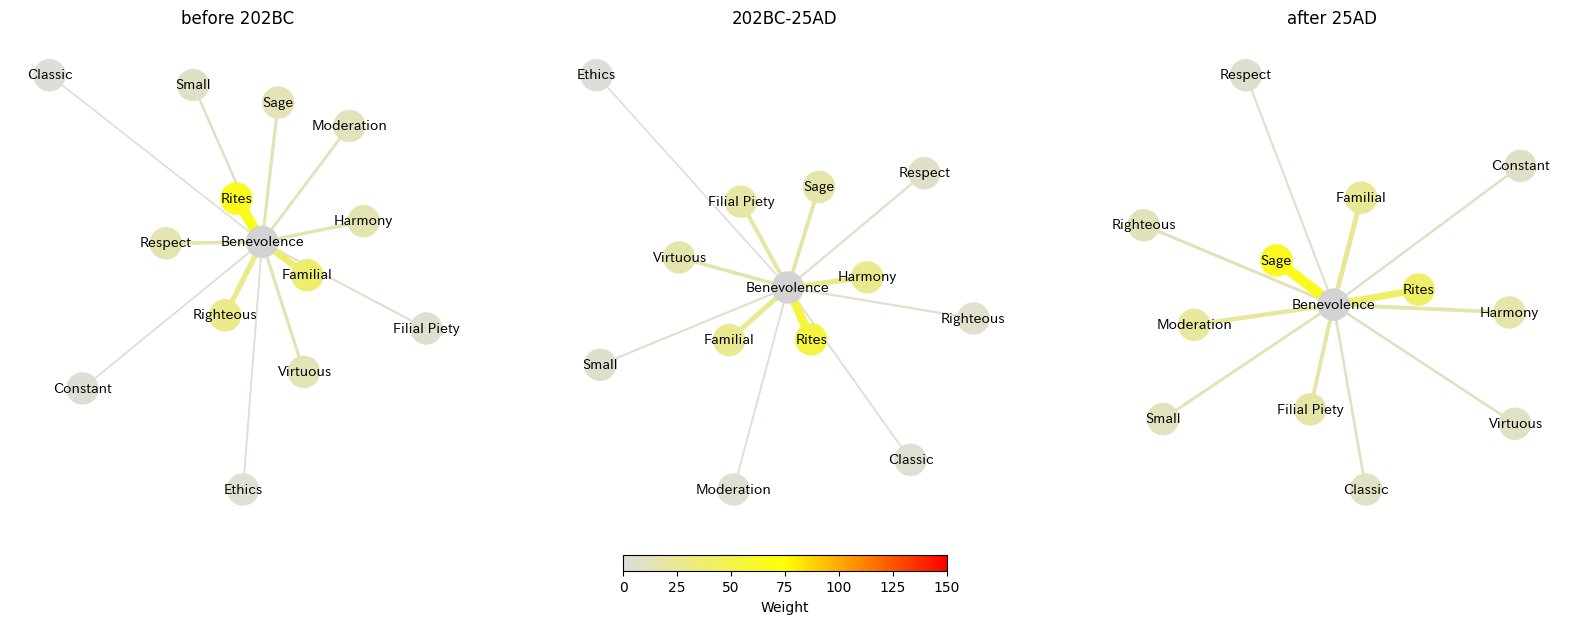

In [96]:
plot_networks(df_ren_Human_Ethics_network)

## Political Governance

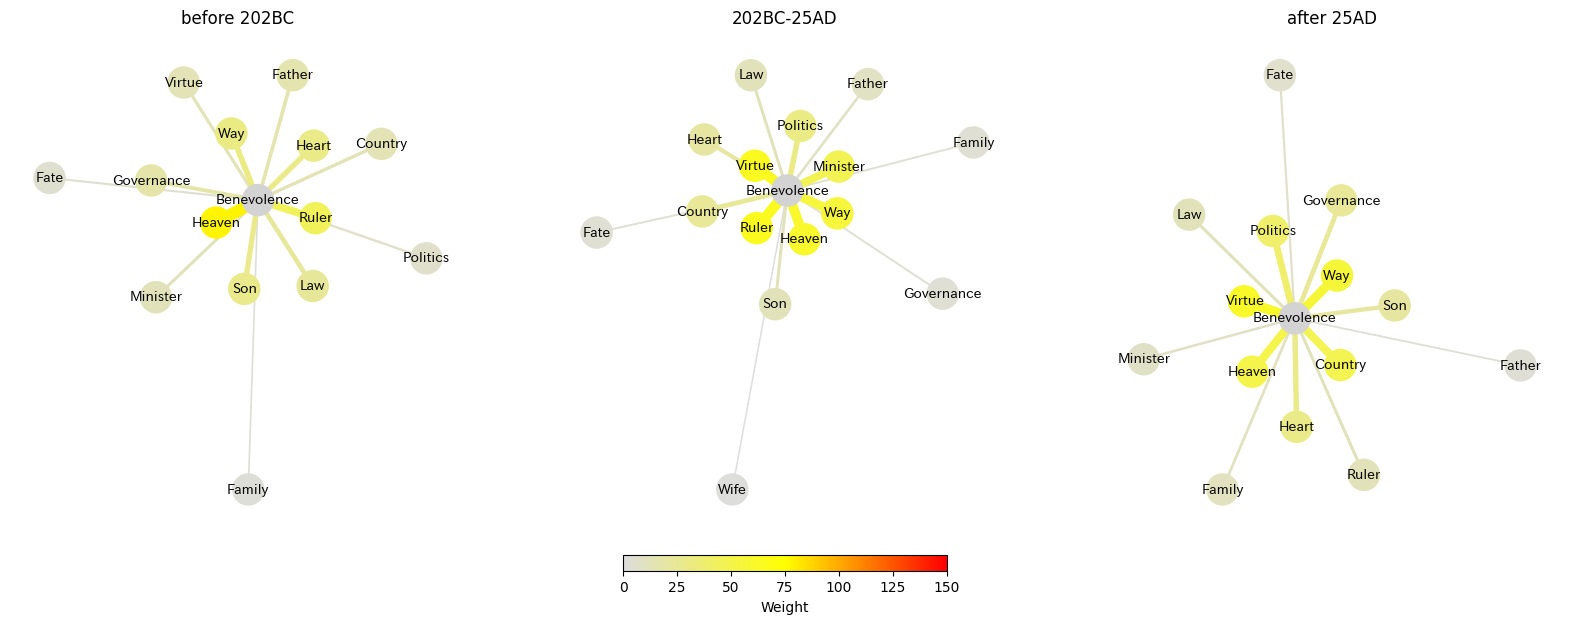

In [102]:
plot_networks(df_ren_Political_network)

## Human Life

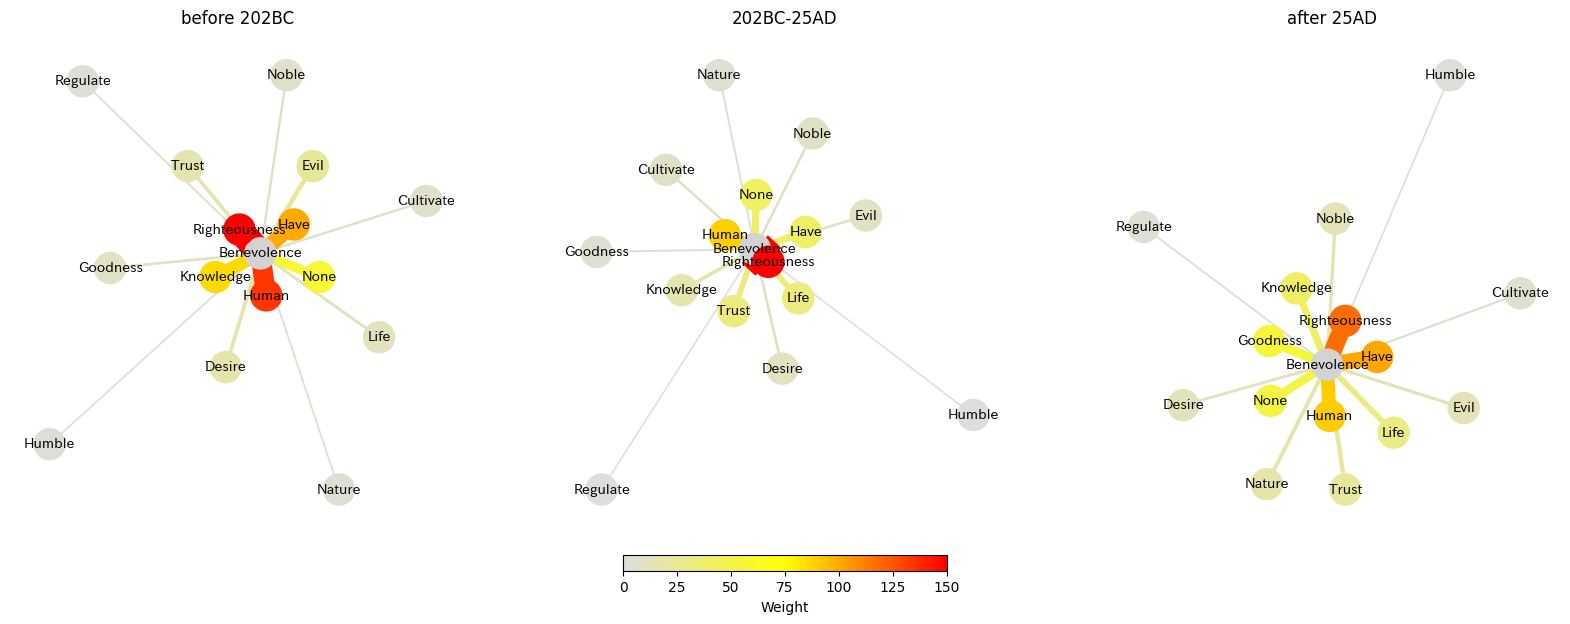

In [100]:
plot_networks(df_ren_Human_Life_network)